# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

## Introdução

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

## Códigos

### Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

import warnings # Biblioteca usada para ocultar os avisos do Executor do Terminal

warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

### Consolidar Base de Dados

In [2]:
# Dicionário criado para podermos referenciar o mês ao nome dos arquivos
meses = {'jan':1, 'fev':2, 'mar':3, 'abr':4, 'mai':5, 'jun':6, 'jul':7 , 'ago':8, 'set': 9, 'out':10, 'nov':11, 'dez':12}

caminho_bases = pathlib.Path('dataset') #nome da pasta

base_airnb = pd.DataFrame() #daframe vazio que será alimentado pelo append mais abaixo no for

for arquivo in caminho_bases.iterdir(): # fazendo a iteração em todos os arquivos dentro da pasta
    nome_mes = arquivo.name[:3] # pegando os três primeiros caracteres do nome do arquivo
    mes = meses[nome_mes] # trazendo o número do mês conforme a chave do dicionário

    ano = arquivo.name[-8:] # trazendo os oito últimos caracteres do nome do arquivo
    ano = int(ano.replace('.csv', '')) # substituindo o nome da extensão por vazio para restar apenas o ano

    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes
    base_airnb = base_airnb.append(df)

In [3]:
base_airnb.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180713234102,2018-07-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180713234102,2018-07-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

In [4]:
print(base_airnb.columns)
# Gerando um arquivo csv com as primeiras 1000 linhas para entendermos quais colunas excluir
base_airnb.head(1000).to_csv('exportacoes_lab/primeiros_mil_registros.csv', sep=';', index=False)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'number_of_reviews_ltm', 'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms'],
      dtype='object', length=108)


- Tendo em vista que existem muitas colunas no dataset, este modelo pode acabar muito lento.
- Além disso, uma análise mais rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da nossa base.
- Tipos de colunas que vamos excluir:
    1. IDs, links e informações não relevantes para o modelo preditivo;
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex "data" e "ano/mes");
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou mineração de texto;
    4. Colunas em que todos ou quase todos os valores são iguais
- Para isso, vamos criar um arquivo em excel com os primeiros mil registros para analisarmos detalhamente cada coluna.

In [5]:
# Verificando quantos itens temos por categoria nesta coluna do dataframe
print(base_airnb[['experiences_offered']].value_counts())

experiences_offered
none                   902210
dtype: int64


In [6]:
# comparando se os valores das colunas são iguais ou na maioria são iguais
print((base_airnb['host_listings_count']==base_airnb['host_total_listings_count']).value_counts())

True     901750
False       460
dtype: int64


In [7]:
columns = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','maximum_nights','is_business_travel_ready','cancellation_policy','ano','mes']

In [8]:
base_airnb_uteis = base_airnb.loc[:,columns]

In [9]:
base_airnb_uteis.head(2)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,maximum_nights,is_business_travel_ready,cancellation_policy,ano,mes
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,f,365,f,strict_14_with_grace_period,2018,7
1,within an hour,100%,f,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,10.0,10.0,9.0,9.0,t,90,f,strict_14_with_grace_period,2018,7


### Tratar Valores Faltando

Visualizando os dados, percebemos que há colunas com muitos valores nulos. Como decisão para análise, excluiremos todas as colunas que possuem mais de 300 mil linhas com valores nulos.

In [10]:
#Excluindo as colunas com linhas com valores nulos acima de 300 mil

for coluna in base_airnb_uteis:
    if base_airnb_uteis[coluna].isnull().sum() > 300_000:
        base_airnb_uteis = base_airnb_uteis.drop(coluna, axis=1)

print(base_airnb_uteis.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
number_of_reviews              0
instant_bookable               0
maximum_nights                 0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [11]:
print(base_airnb_uteis.shape) # Visualizando quantas linhas e colunas o dataframe tem

(902210, 23)


In [12]:
base_airnb_uteis = base_airnb_uteis.dropna() # Excluindo linhas com valores nulos (para os casos que possuem apenas na casa de milhares)
print(base_airnb_uteis.shape)

(897709, 23)


In [13]:
print(base_airnb_uteis.isnull().sum())

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
number_of_reviews           0
instant_bookable            0
maximum_nights              0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [14]:
print(base_airnb_uteis.dtypes)


host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
number_of_reviews             int64
instant_bookable             object
maximum_nights                int64
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


In [15]:
print(base_airnb_uteis.iloc[0])

host_is_superhost                                                           f
host_listings_count                                                       1.0
latitude                                                           -22.946854
longitude                                                          -43.182737
property_type                                                       Apartment
room_type                                                     Entire home/apt
accommodates                                                                4
bathrooms                                                                 1.0
bedrooms                                                                  0.0
beds                                                                      2.0
bed_type                                                             Real Bed
amenities                   {TV,Internet,"Air conditioning",Kitchen,Doorma...
price                                                           

Como price e extra_people estão sendo lidas como string (object), precisaremos trabalhar esses dados para que sejam lidos como float

In [16]:
#corrigindo a coluna price
base_airnb_uteis['price'] = base_airnb_uteis['price'].str.replace('$', '')
base_airnb_uteis['price'] = base_airnb_uteis['price'].str.replace(',', '')
base_airnb_uteis['price'] = base_airnb_uteis['price'].astype(np.float32, copy=False)

#Corrigindo a coluna extra_people
base_airnb_uteis['extra_people'] = base_airnb_uteis['extra_people'].str.replace('$', '')
base_airnb_uteis['extra_people'] = base_airnb_uteis['extra_people'].str.replace(',', '')
base_airnb_uteis['extra_people'] = base_airnb_uteis['extra_people'].astype(np.float32, copy=False)

In [17]:
print(base_airnb_uteis.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
number_of_reviews             int64
instant_bookable             object
maximum_nights                int64
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

1. Verificar a correlação entre as features e decidir se manteremos todas as que temos.
2. Excluir outliers (usaremos como regra, valores abaixo do 1º Quartil subtraindo a multiplicação de 1,5 x amplitude e valores acima do 3º quartil somada a multiplicação de 1,5 x amplitude). Amplitude para essa análise é igual ao 3º quartil menos o 1º quartil
3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir.

* Vamos começar pelas colunas de preço (resultado final desejado) e de extra_people (também é valor monetário). Valores numéricos contínuos.

* Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc)

* Avaliação das colunas de texto para definição de quais categorias fazem sentido ou não para este projeto.

<AxesSubplot:>

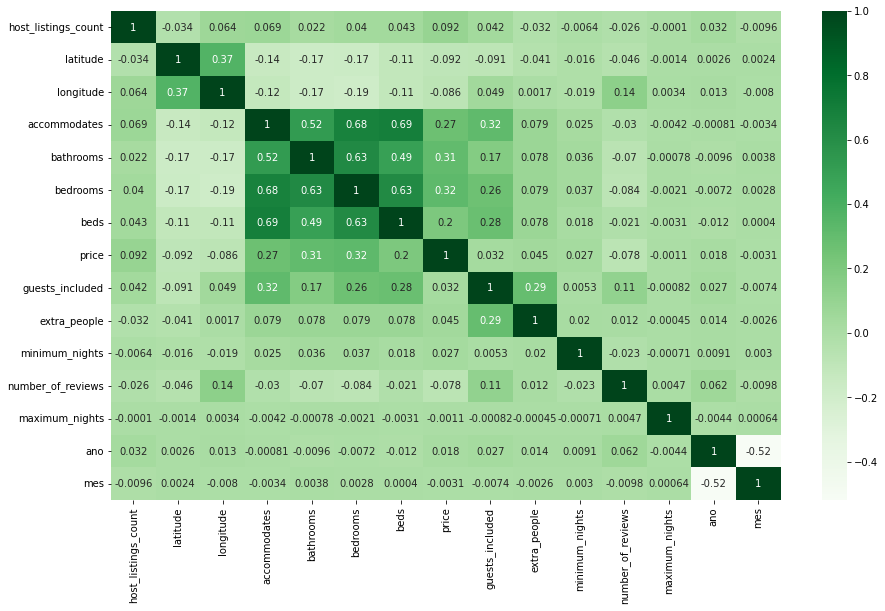

In [18]:
#Análise de correlação:

#print(base_airnb_uteis.corr())

plt.figure(figsize=(15, 9))
sns.heatmap(base_airnb_uteis.corr(), annot=True, cmap='Greens')

Conforme exibido pelo mapa de calor, não identificamos correlações fortes entre as colunas a ponto de possibilitar enviesamento do modelo que iremos estruturar.

#### Definição de funções para análise de outliers
##### Vamos definir algumas funções para ajudar na análise de outliers das colunas

In [19]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

In [20]:
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas -  df.shape[0]
    return df, linhas_removidas

In [21]:
def diagrama_boxplot(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

In [22]:
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna, hist=True)

In [23]:
def grafico_barra(coluna):
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### Análise do campo price

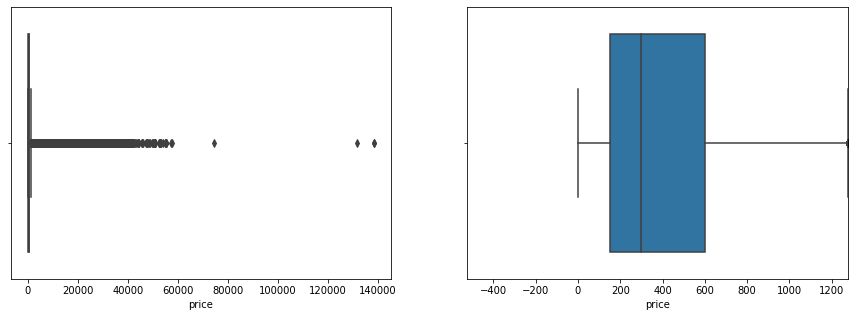

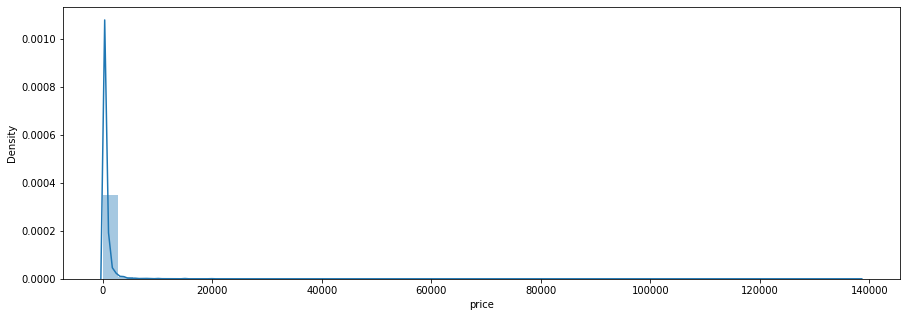

In [24]:
diagrama_boxplot(base_airnb_uteis['price'])
histograma(base_airnb_uteis['price'])

Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, fora do escopo deste projeto. Desta forma, podemos excluir estes outliers

In [25]:
# Exclusão de outliers
base_airnb_uteis, linhas_removidas = excluir_outliers(base_airnb_uteis, 'price')
print(f'{linhas_removidas} linhas removidas!')

87282 linhas removidas!


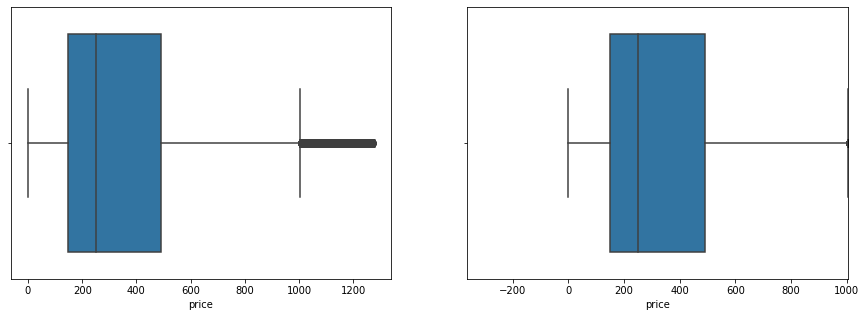

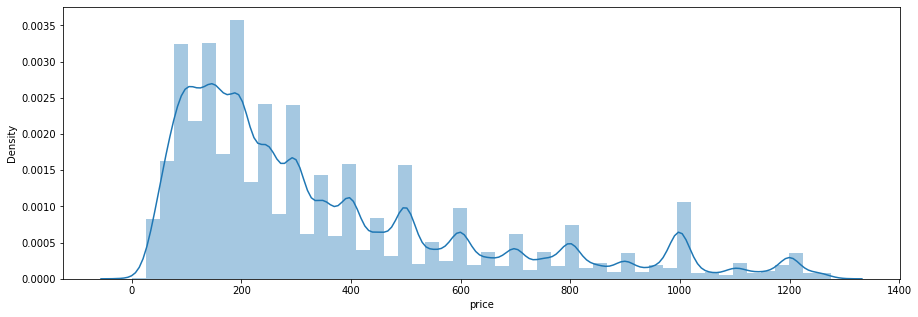

In [26]:
# Visualização da análise da coluna preço após exclusão dos outliers
diagrama_boxplot(base_airnb_uteis['price'])
histograma(base_airnb_uteis['price'])

#### Analisando a coluna extra_people
Valor numérico contínuo

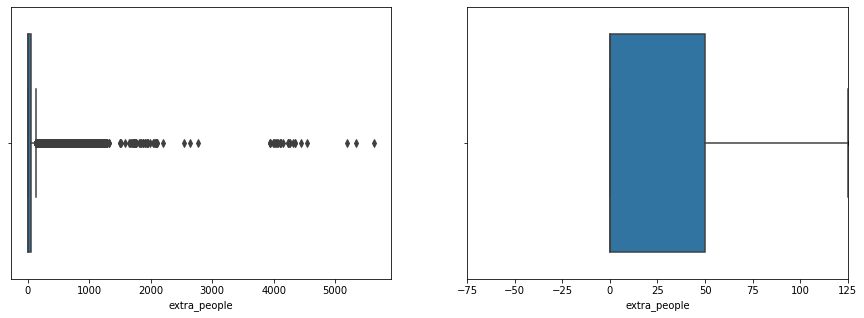

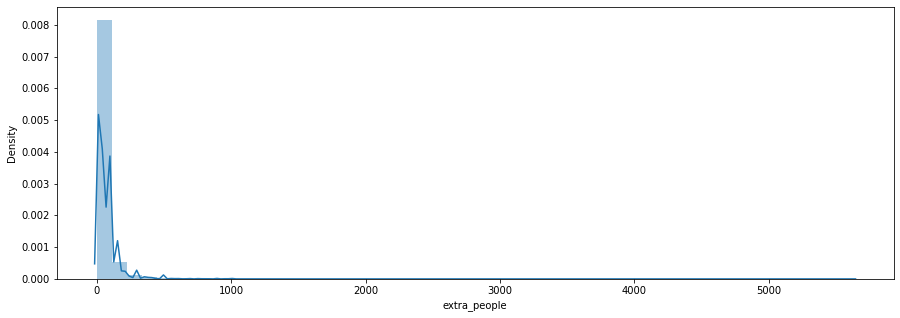

In [27]:
diagrama_boxplot(base_airnb_uteis['extra_people'])
histograma(base_airnb_uteis['extra_people'])

In [28]:
# Exclusão de outliers
base_airnb_uteis, linhas_removidas = excluir_outliers(base_airnb_uteis, 'extra_people')
print(f'{linhas_removidas} linhas removidas!')

59194 linhas removidas!


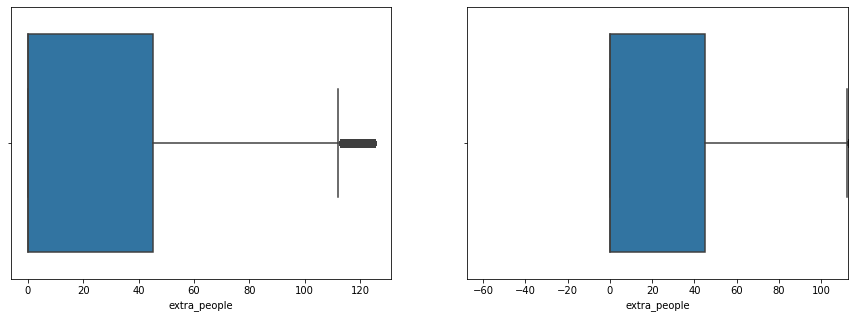

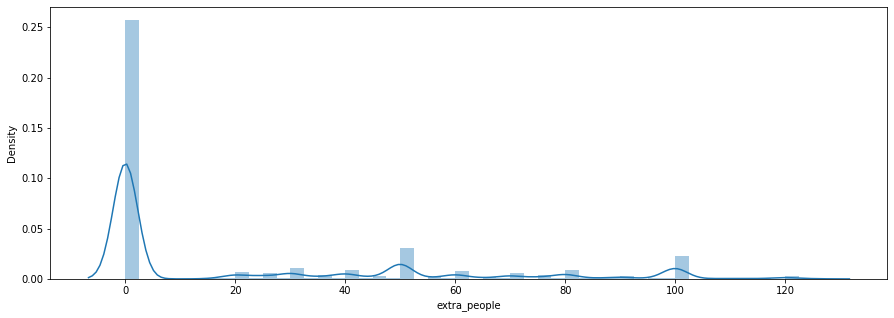

In [29]:
# Visualizando os gráficos sem os outliers
diagrama_boxplot(base_airnb_uteis['extra_people'])
histograma(base_airnb_uteis['extra_people'])

Outliers excluídos também neste campo tendo em vista que a primeira hipótese levantada no projeto foi de que o valor extra cobrado por pessoa tende a ser relevante para calcularmos o valor final do imóvel.

#### Análise: host_listings_count

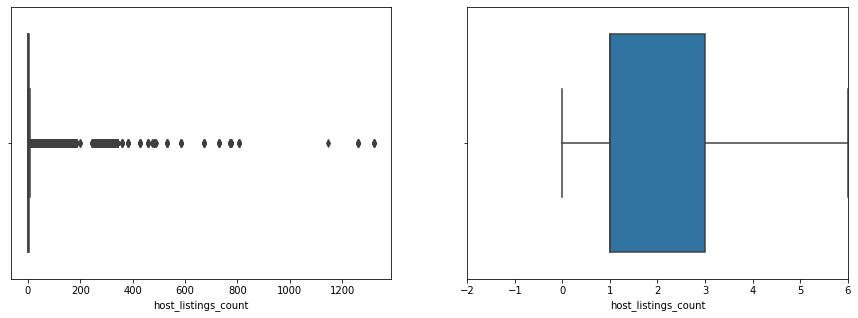

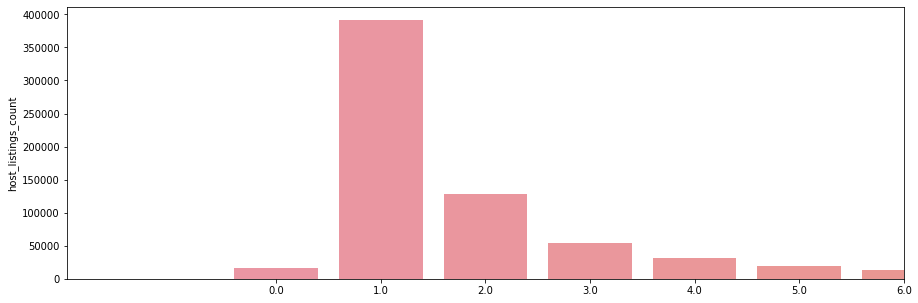

In [30]:
diagrama_boxplot(base_airnb_uteis['host_listings_count'])
grafico_barra(base_airnb_uteis['host_listings_count'])

Iremos excluir as linhas com pessoas que possuem mais que 6 imóveis na plataforma, uma vez que esse perfil de locatário não está no objetivo primário do projeto.

In [31]:
# Exclusão de outliers
base_airnb_uteis, linhas_removidas = excluir_outliers(base_airnb_uteis, 'host_listings_count')
print(f'{linhas_removidas} linhas removidas!')

97723 linhas removidas!


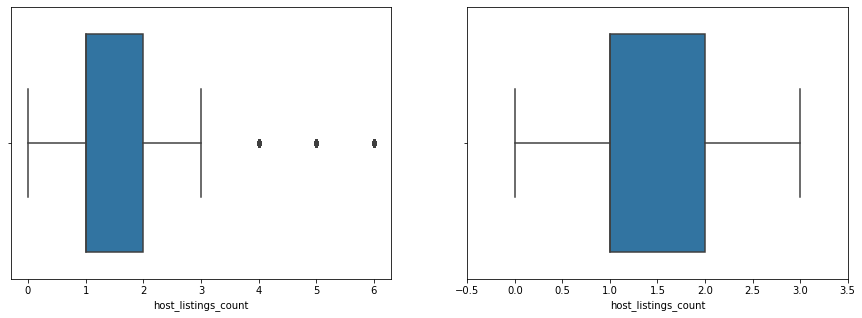

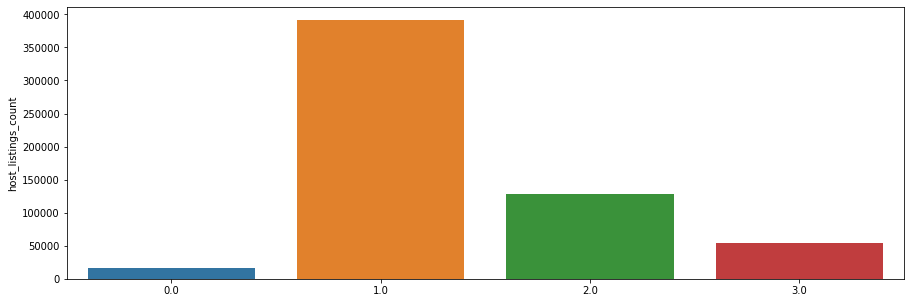

In [32]:
# Visualizando os gráficos após exclusão dos outliers
diagrama_boxplot(base_airnb_uteis['host_listings_count'])
grafico_barra(base_airnb_uteis['host_listings_count'])

#### Análise accommodates

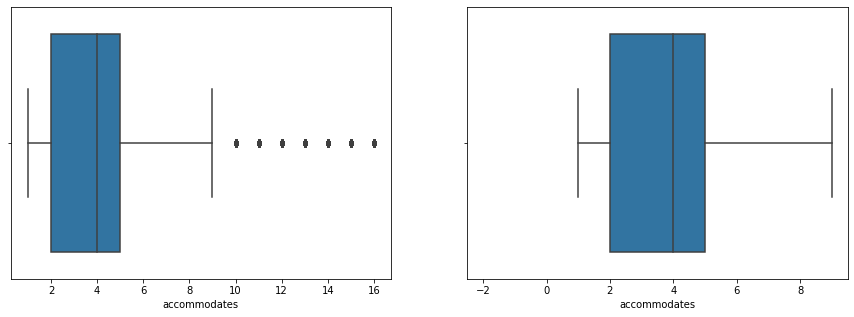

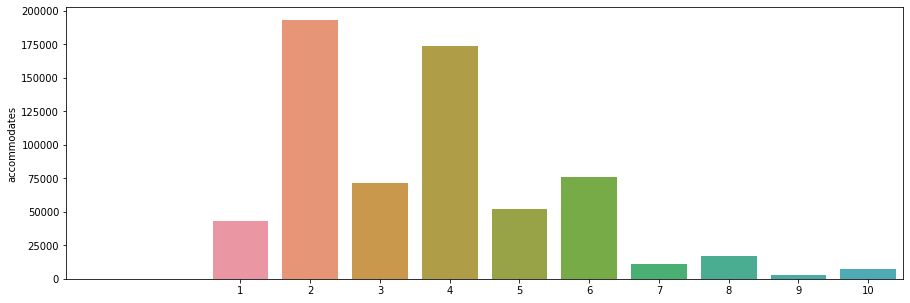

In [33]:
diagrama_boxplot(base_airnb_uteis['accommodates'])
grafico_barra(base_airnb_uteis['accommodates'])

In [34]:
# Exclusão de outliers
base_airnb_uteis, linhas_removidas = excluir_outliers(base_airnb_uteis, 'accommodates')
print(f'{linhas_removidas} linhas removidas!')

13146 linhas removidas!


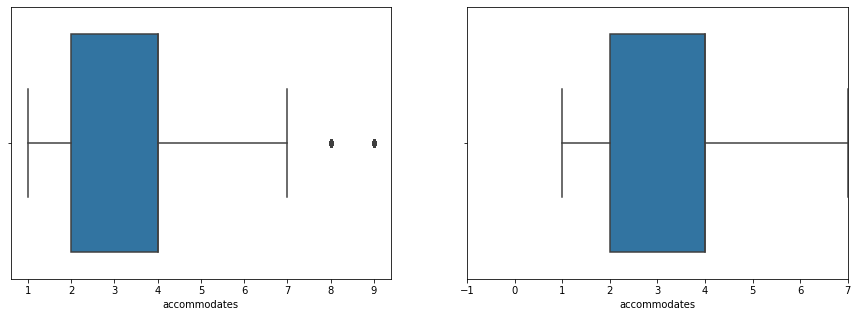

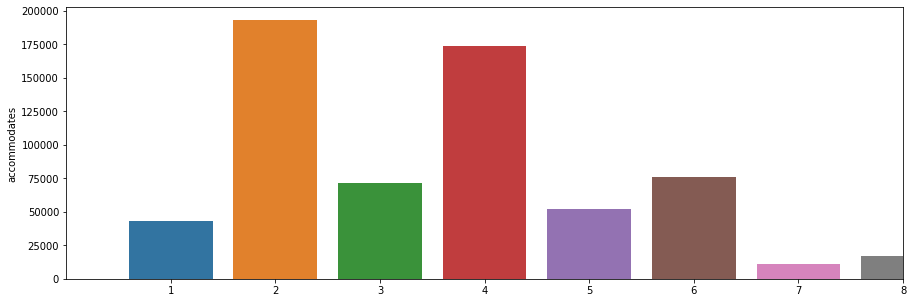

In [35]:
# Visualizando os gráficos após exclusão dos outliers
diagrama_boxplot(base_airnb_uteis['accommodates'])
grafico_barra(base_airnb_uteis['accommodates'])

#### Análise bathrooms

<AxesSubplot:ylabel='bathrooms'>

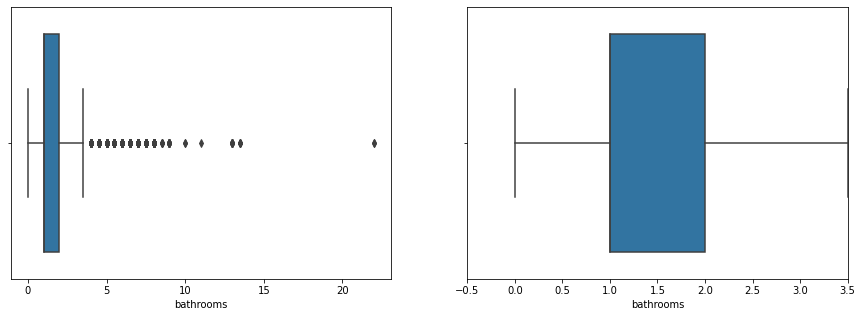

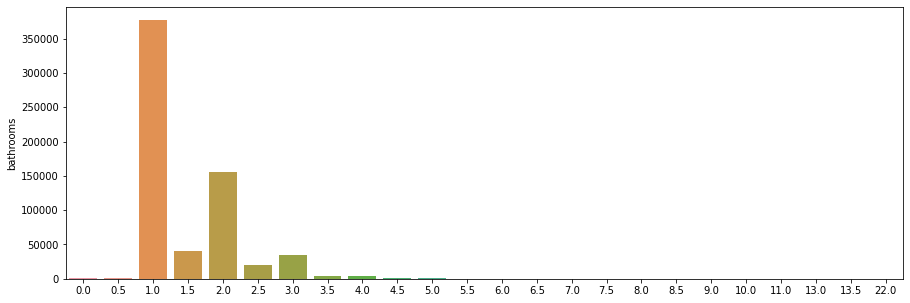

In [36]:
diagrama_boxplot(base_airnb_uteis['bathrooms'])
plt.figure(figsize=(15,5))
sns.barplot(x=base_airnb_uteis['bathrooms'].value_counts().index, y=base_airnb_uteis['bathrooms'].value_counts())

In [37]:
# Exclusão de outliers
base_airnb_uteis, linhas_removidas = excluir_outliers(base_airnb_uteis, 'bathrooms')
print(f'{linhas_removidas} linhas removidas!')

6894 linhas removidas!


<AxesSubplot:ylabel='bathrooms'>

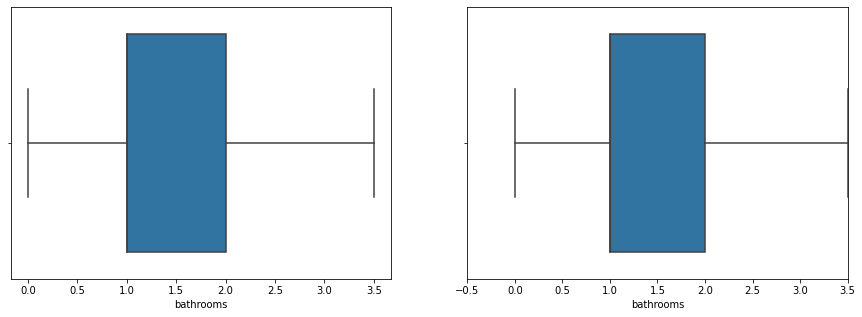

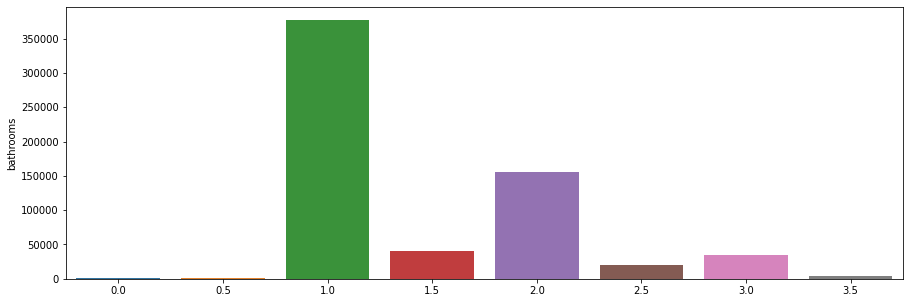

In [38]:
# Visualizando os gráficos após exclusão dos outliers
diagrama_boxplot(base_airnb_uteis['bathrooms'])
plt.figure(figsize=(15,5))
sns.barplot(x=base_airnb_uteis['bathrooms'].value_counts().index, y=base_airnb_uteis['bathrooms'].value_counts())

#### Análise bedrooms

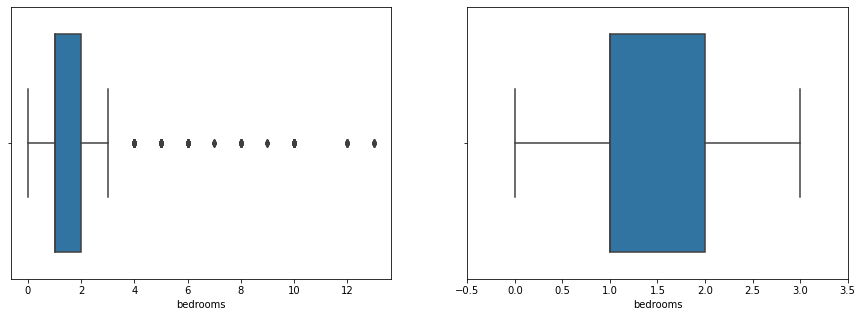

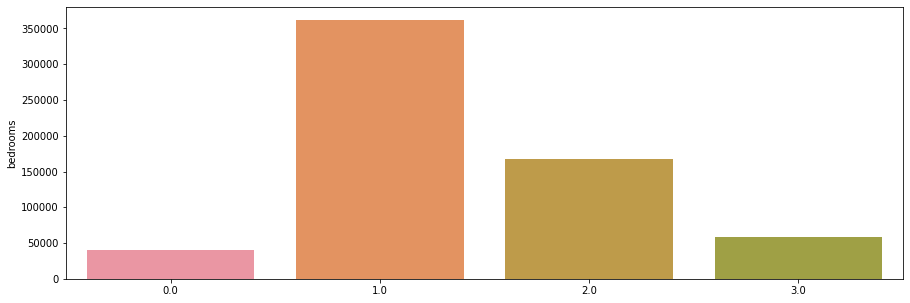

In [39]:
diagrama_boxplot(base_airnb_uteis['bedrooms'])
grafico_barra(base_airnb_uteis['bedrooms'])

In [40]:
# Exclusão de outliers
base_airnb_uteis, linhas_removidas = excluir_outliers(base_airnb_uteis, 'bedrooms')
print(f'{linhas_removidas} linhas removidas!')

5482 linhas removidas!


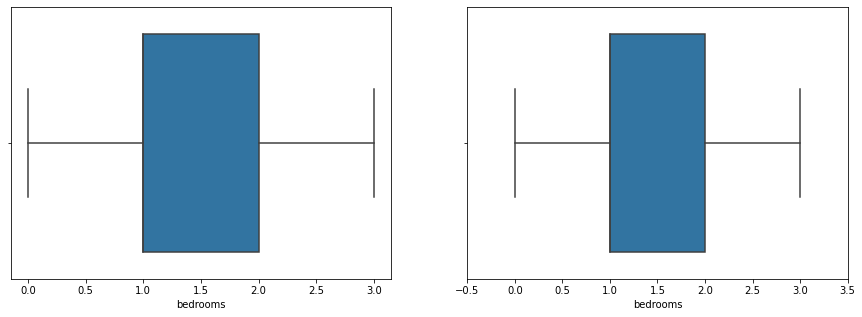

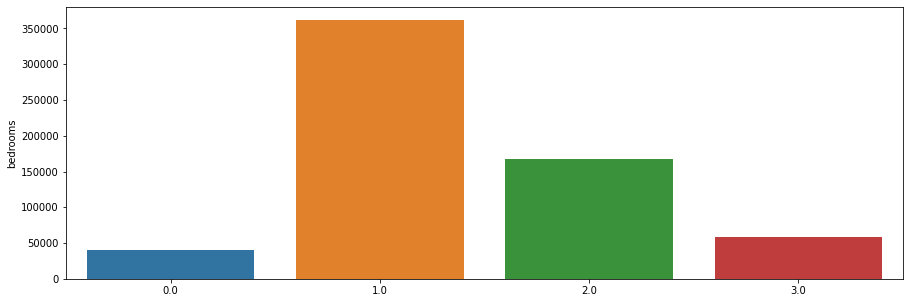

In [41]:
# Visualizando os gráficos após exclusão dos outliers
diagrama_boxplot(base_airnb_uteis['bedrooms'])
grafico_barra(base_airnb_uteis['bedrooms'])

#### Análise Beds

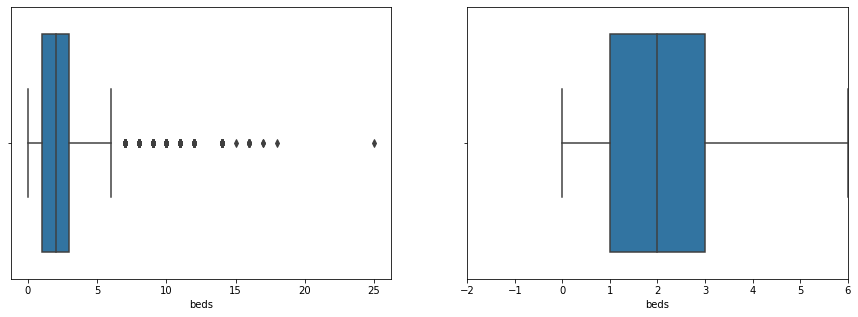

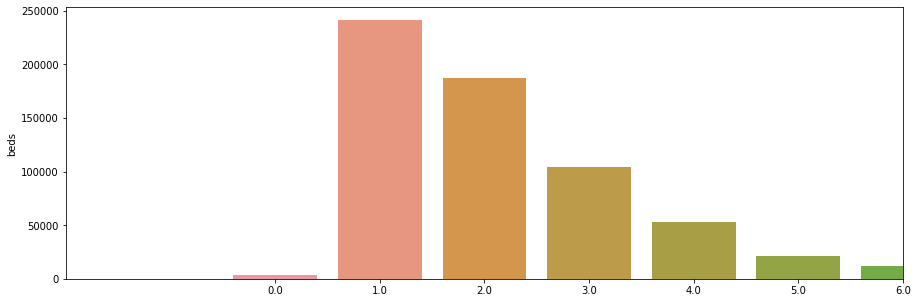

In [42]:
diagrama_boxplot(base_airnb_uteis['beds'])
grafico_barra(base_airnb_uteis['beds'])

In [43]:
# Exclusão de outliers
base_airnb_uteis, linhas_removidas = excluir_outliers(base_airnb_uteis, 'beds')
print(f'{linhas_removidas} linhas removidas!')

5622 linhas removidas!


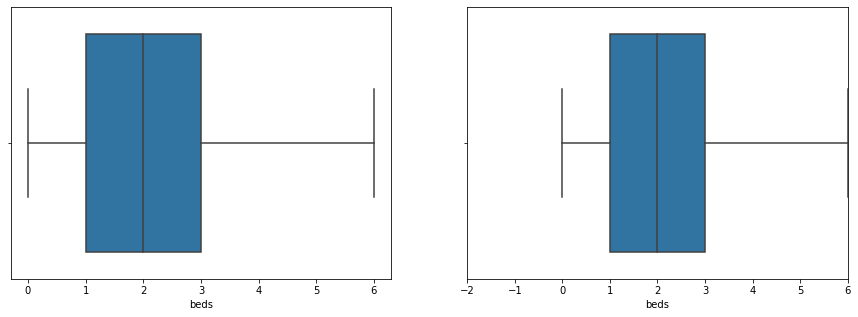

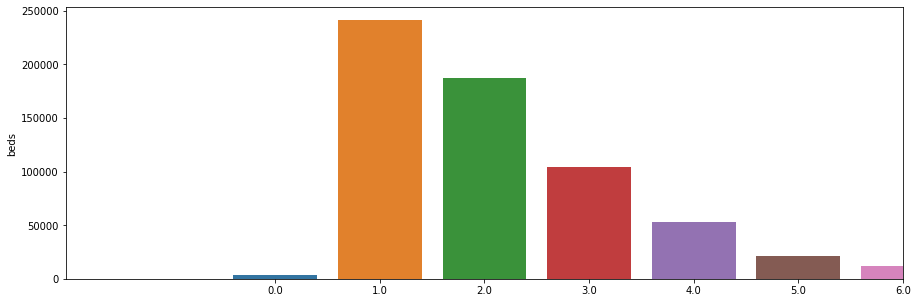

In [44]:
diagrama_boxplot(base_airnb_uteis['beds'])
grafico_barra(base_airnb_uteis['beds'])

#### Análise guests_included

(1.0, 1.0)


<AxesSubplot:ylabel='guests_included'>

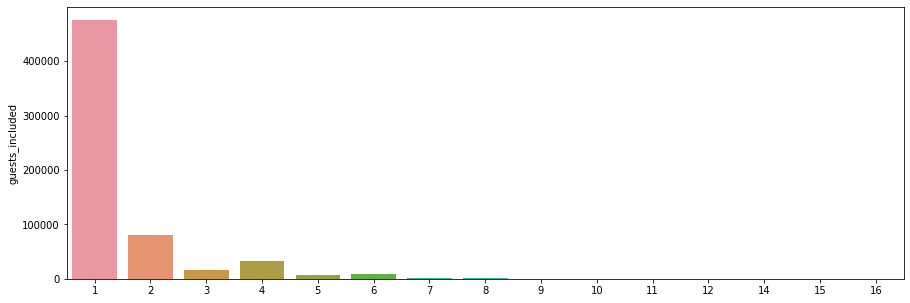

In [45]:
#diagrama_boxplot(base_airnb_uteis['guests_included'])
#grafico_barra(base_airnb_uteis['guests_included'])
print(limites(base_airnb_uteis['guests_included']))
plt.figure(figsize=(15,5))
sns.barplot(x=base_airnb_uteis['guests_included'].value_counts().index, y=base_airnb_uteis['guests_included'].value_counts())

Vamos remover essa coluna da análise. Aparentemente os usuários da plataforma usam muito o valor padrão de 1 para as pessoas inclusas na locação. Por esta razão, parece uma melhor decisão a exclusão dela da análise.

In [46]:
base_airnb_uteis = base_airnb_uteis.drop('guests_included', axis=1)

In [47]:
base_airnb_uteis.shape

(622366, 22)

#### Análise minimum_nights 

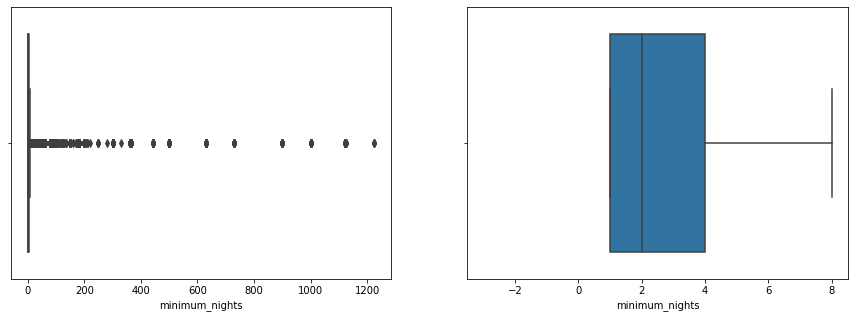

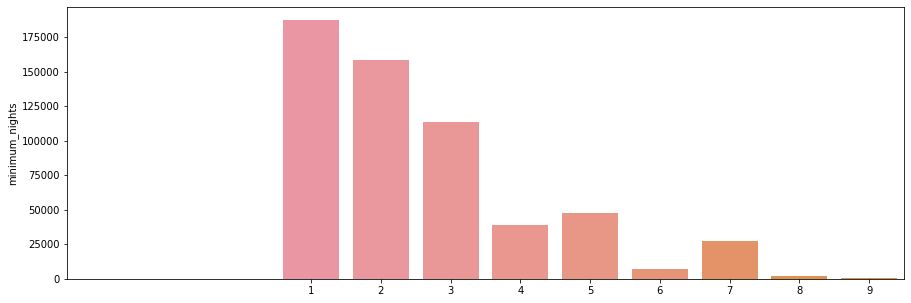

In [48]:
diagrama_boxplot(base_airnb_uteis['minimum_nights'])
grafico_barra(base_airnb_uteis['minimum_nights'])

In [49]:
# Exclusão de outliers
base_airnb_uteis, linhas_removidas = excluir_outliers(base_airnb_uteis, 'minimum_nights')
print(f'{linhas_removidas} linhas removidas!')

40383 linhas removidas!


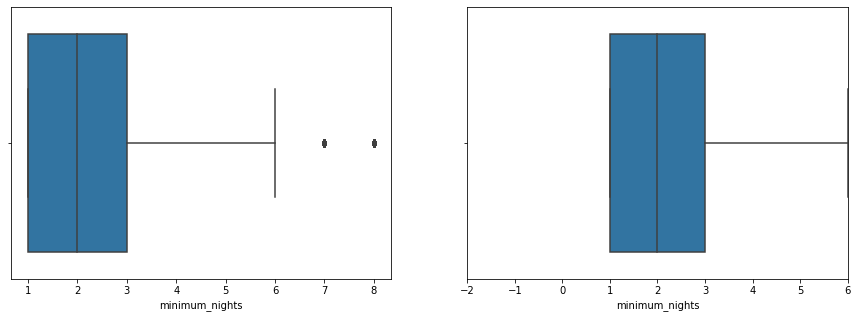

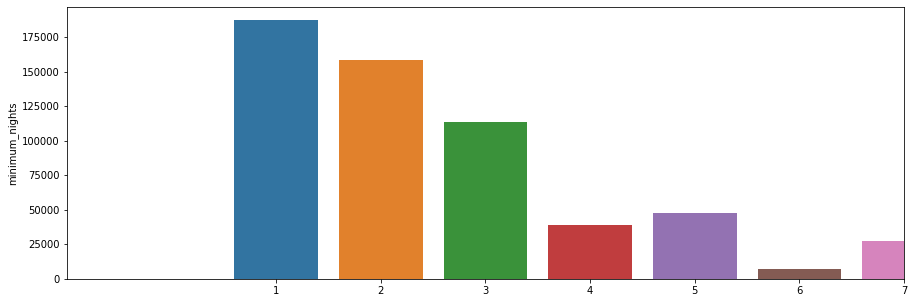

In [50]:
diagrama_boxplot(base_airnb_uteis['minimum_nights'])
grafico_barra(base_airnb_uteis['minimum_nights'])

#### Análise maximum_nights 

(-1612.5, 2767.5)


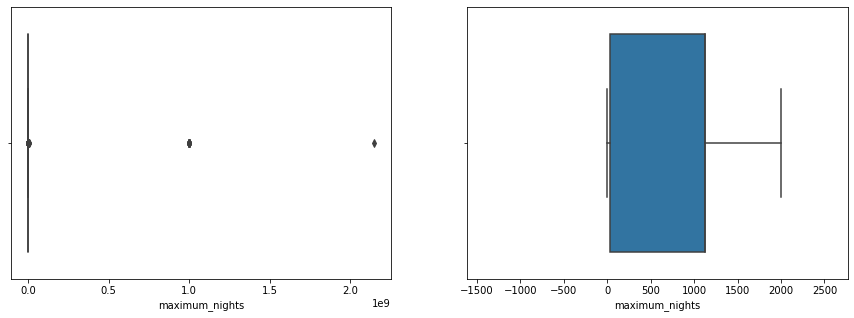

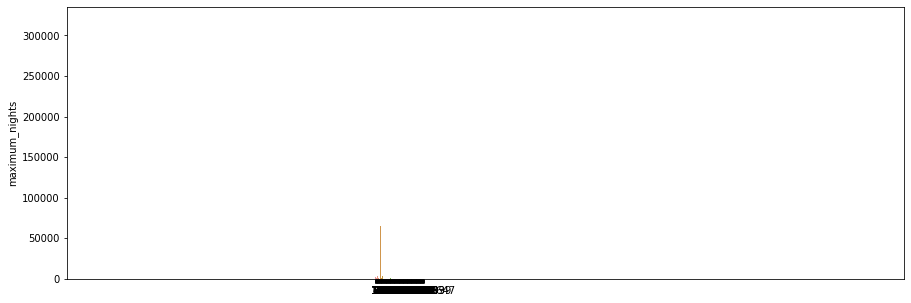

In [51]:
diagrama_boxplot(base_airnb_uteis['maximum_nights'])
grafico_barra(base_airnb_uteis['maximum_nights'])
print(limites(base_airnb_uteis['maximum_nights']))

Analisando o campo maximum_nights, podemos observar que essa aparentemente é uma informação que não é preenchiida pelos locatários, havendo enorme disparidade entre os casos com 0 e grandes valores como 2.000 dias.

In [52]:
# Excluindo a coluna
base_airnb_uteis = base_airnb_uteis.drop('maximum_nights', axis=1)

#### Análise number_of_reviews

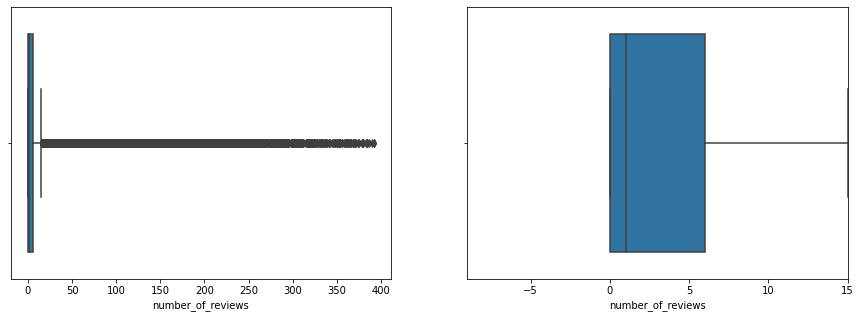

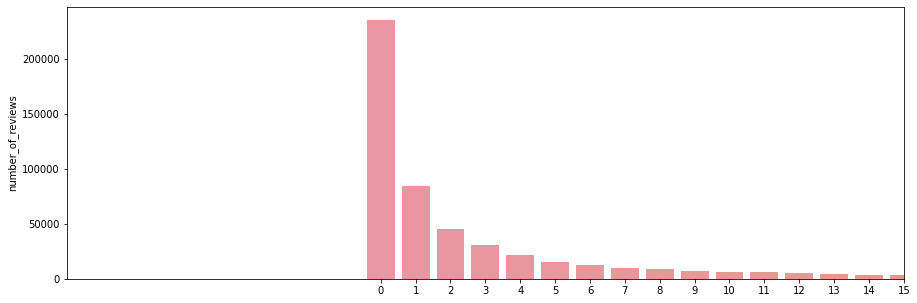

In [53]:
diagrama_boxplot(base_airnb_uteis['number_of_reviews'])
grafico_barra(base_airnb_uteis['number_of_reviews'])

Como o objetivo deste projeto é montar o melhor modelo de previsão de preço para novos usuários da plataforma, o grande número de avaliações não vai ser um item relevante para esta finalidade.

In [54]:
# Excluindo a coluna
base_airnb_uteis = base_airnb_uteis.drop('number_of_reviews', axis=1)
base_airnb_uteis.shape

(581983, 20)

### Tratamento das colunas com valores de texto

- property_type

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

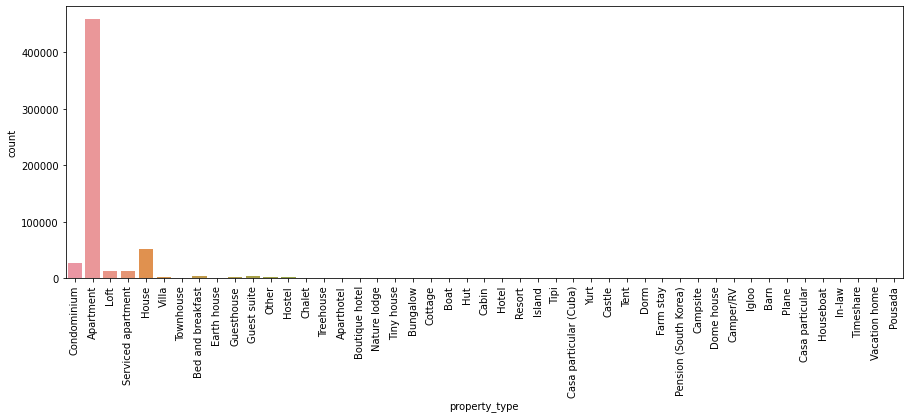

In [55]:
print(base_airnb_uteis['property_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('property_type', data=base_airnb_uteis)
grafico.tick_params(axis='x', rotation=90)

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'In-law', 'Igloo', 'Vacation home', 'Houseboat', 'Timeshare', 'Pousada', 'Casa particular', 'Plane']


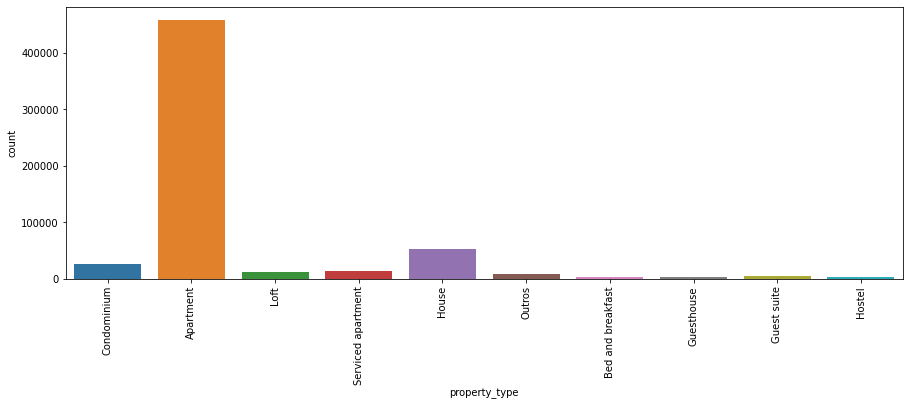

In [56]:
# Agrupando categorias de property_type
tabela_tipos_casa = base_airnb_uteis['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)

print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airnb_uteis.loc[base_airnb_uteis['property_type'] == tipo, 'property_type'] = 'Outros'

plt.figure(figsize=(15,5))
grafico = sns.countplot('property_type', data=base_airnb_uteis)
grafico.tick_params(axis='x', rotation=90)

### room_type

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


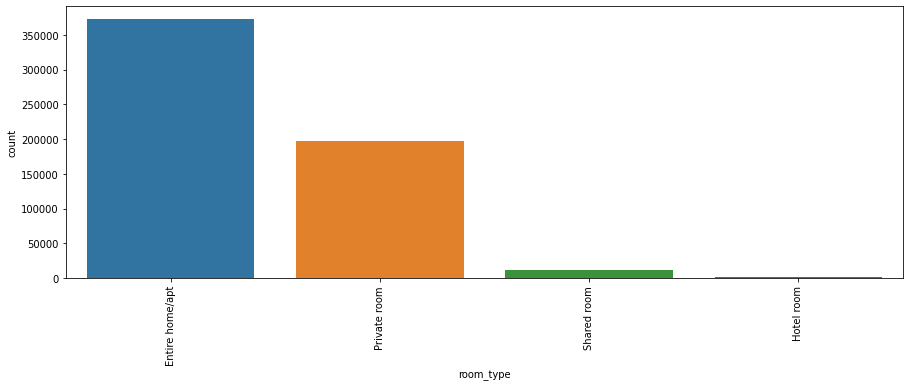

In [57]:
print(base_airnb_uteis['room_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('room_type', data=base_airnb_uteis)
grafico.tick_params(axis='x', rotation=90)

### bed_type

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


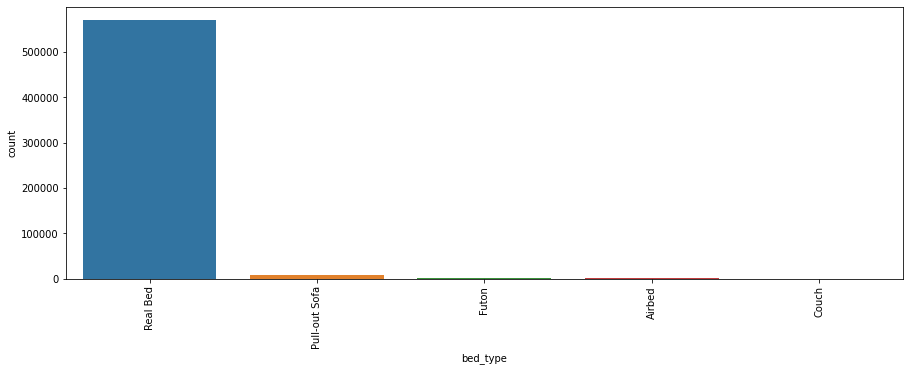

In [58]:
print(base_airnb_uteis['bed_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('bed_type', data=base_airnb_uteis)
grafico.tick_params(axis='x', rotation=90)

['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']


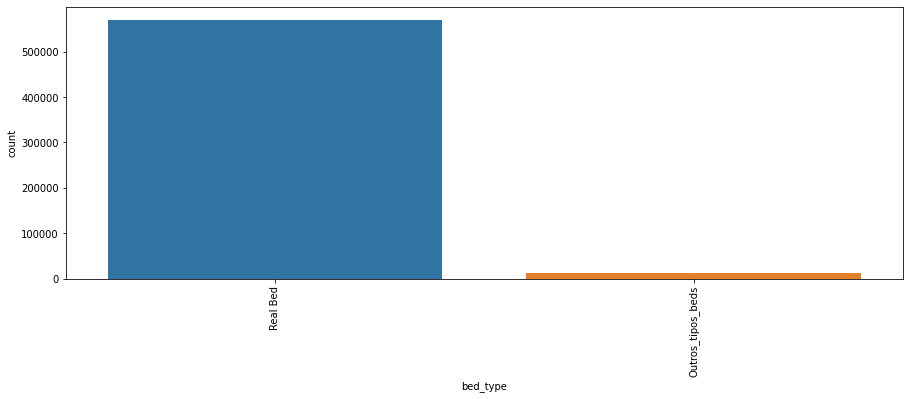

In [59]:
# Agrupando categorias de bed_type
tabela_tipos_cama = base_airnb_uteis['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_cama.index:
    if tabela_tipos_cama[tipo] < 10000:
        colunas_agrupar.append(tipo)

print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airnb_uteis.loc[base_airnb_uteis['bed_type'] == tipo, 'bed_type'] = 'Outros_tipos_beds'

plt.figure(figsize=(15,5))
grafico = sns.countplot('bed_type', data=base_airnb_uteis)
grafico.tick_params(axis='x', rotation=90)

### - cancellation_policy

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


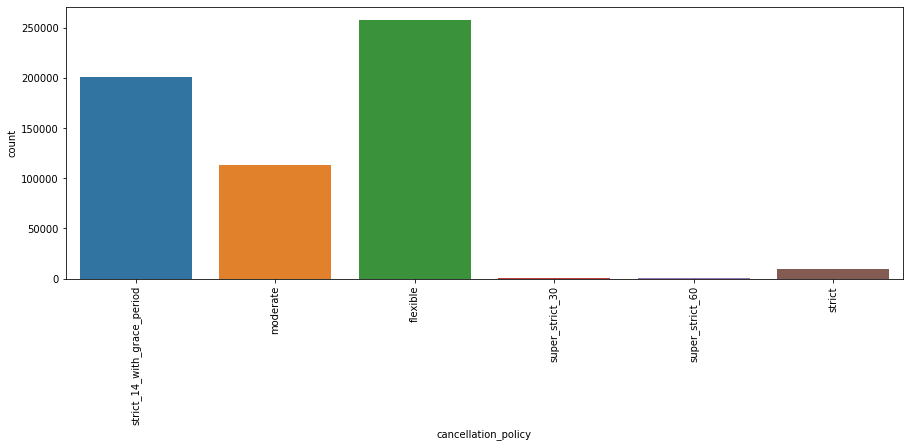

In [60]:
print(base_airnb_uteis['cancellation_policy'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data=base_airnb_uteis)
grafico.tick_params(axis='x', rotation=90)

['strict', 'super_strict_60', 'super_strict_30']


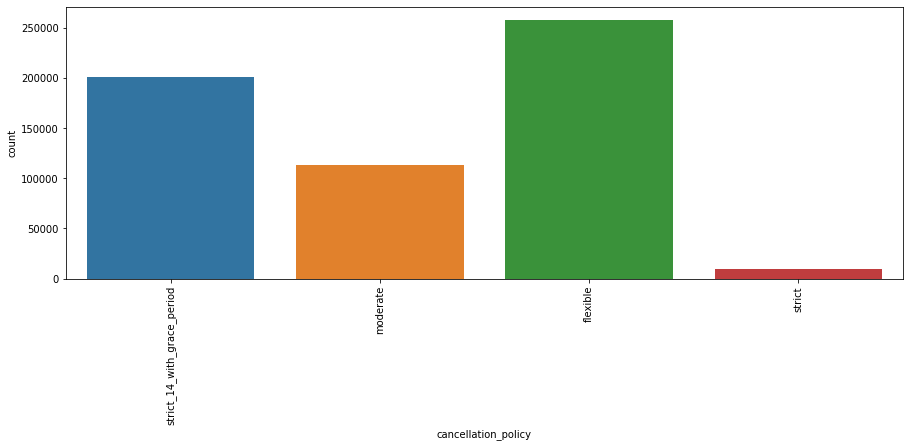

In [61]:
# Agrupando categorias de cancellation_policy
tabela_cancellation = base_airnb_uteis['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)

print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airnb_uteis.loc[base_airnb_uteis['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict'

plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data=base_airnb_uteis)
grafico.tick_params(axis='x', rotation=90)

#### - amenities

Tendo em vista que cada campo deste possui vários itens separados por vírgula e cada host pode descrever esses itens de forma diferente, vamos fazer a contagem de quantos amenitties cada imóvel tem.

In [62]:
print(base_airnb_uteis['amenities'].iloc[0].split(','))
print(len(base_airnb_uteis['amenities'].iloc[0].split(',')))

base_airnb_uteis['numero_amenities'] = base_airnb_uteis['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', '"Paid parking off premises"', '"Smoking allowed"', 'Doorman', 'Elevator', '"Hot tub"', '"Family/kid friendly"', '"Suitable for events"', 'Essentials', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Self check-in"', '"Building staff"', '"Private entrance"', '"Hot water"', '"Bed linens"', '"Luggage dropoff allowed"}']
25


In [63]:
base_airnb_uteis = base_airnb_uteis.drop('amenities', axis=1)
base_airnb_uteis.shape

(581983, 20)

#### - Analisando a nova coluna número_amenities

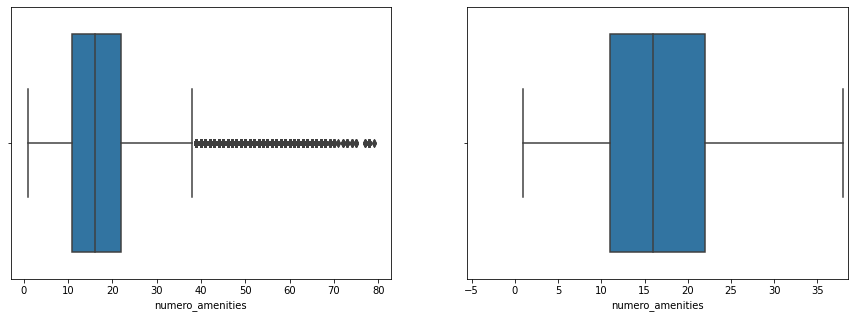

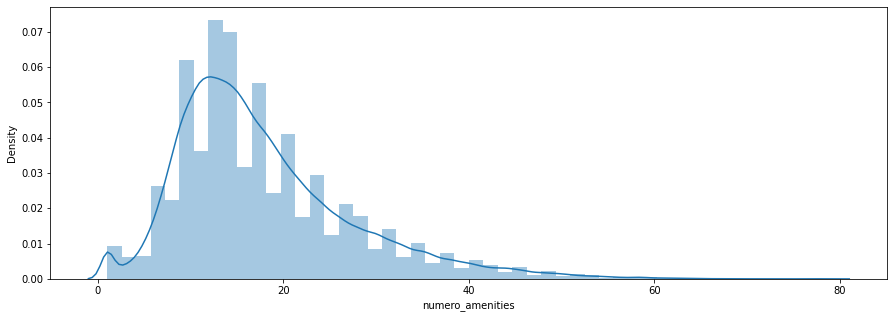

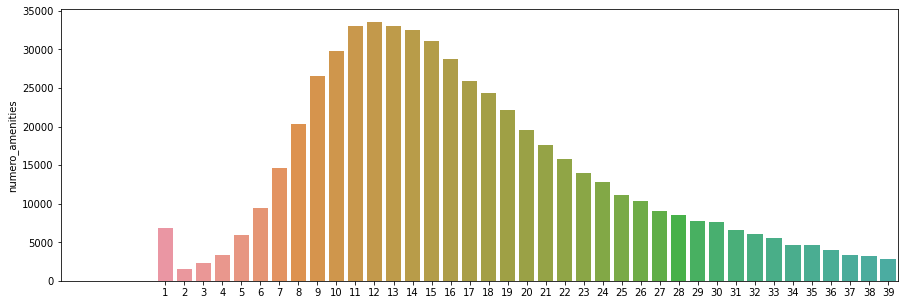

In [64]:
# Visualização prévia
diagrama_boxplot(base_airnb_uteis['numero_amenities'])
histograma(base_airnb_uteis['numero_amenities'])
grafico_barra(base_airnb_uteis['numero_amenities'])

In [65]:
# Exclusão de outliers
base_airnb_uteis, linhas_removidas = excluir_outliers(base_airnb_uteis, 'numero_amenities')
print(f'{linhas_removidas} linhas removidas!')

24343 linhas removidas!


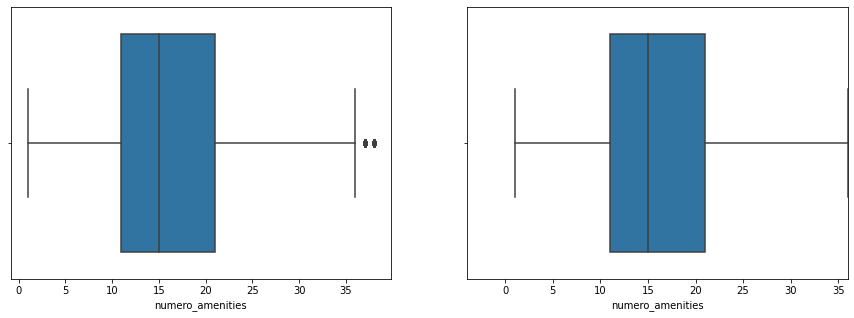

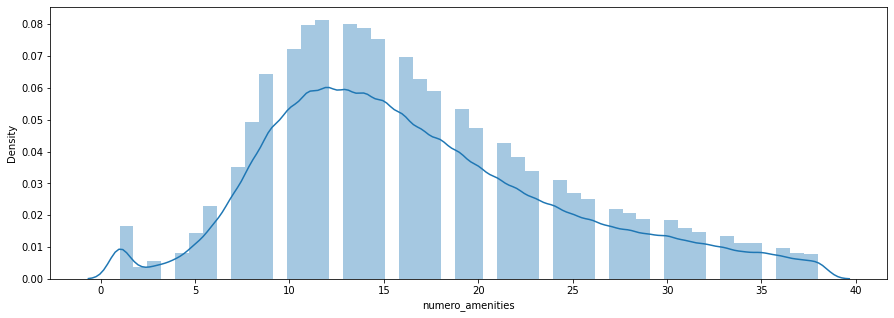

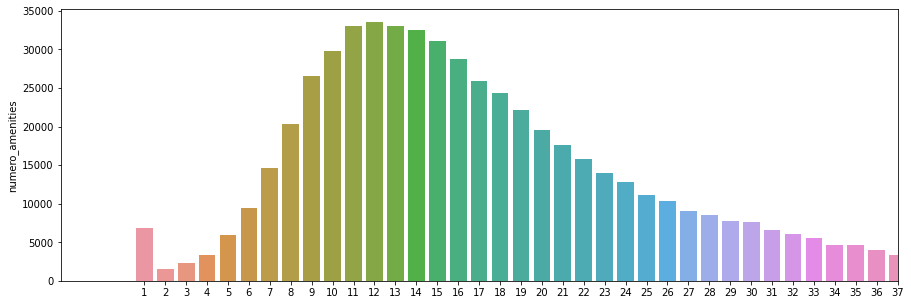

In [66]:
# Visualização da análise da coluna preço após exclusão dos outliers
diagrama_boxplot(base_airnb_uteis['numero_amenities'])
histograma(base_airnb_uteis['numero_amenities'])
grafico_barra(base_airnb_uteis['numero_amenities'])

- ### Visualização de Mapa das Propriedades

In [67]:
# Código para visualização do mapa:

amostra = base_airnb_uteis.sample(n=50000)
centro_mapa = {'lat': amostra.latitude.mean(), 'lon': amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude',
                                 lon='longitude',
                                 z='price',
                                 radius=2.5,
                                 center=centro_mapa,
                                 zoom=10,
                                 mapbox_style='stamen-terrain')

mapa.show()

### Encoding

Será necessário ajustar as colunas para facilitarmos o trabalho do modelo de previsão.

- Colunas com valores booleanos, vamos substituir por 1 quando True e 0 quando False
- Colunas com variáveis categóricas iremos utilizar o método de encoding de variáveis dummies

In [68]:
colunas_booleanas = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airnb_enconding = base_airnb_uteis.copy()

for coluna in colunas_booleanas:
    base_airnb_enconding.loc[base_airnb_enconding[coluna] == 't', coluna] = 1
    base_airnb_enconding.loc[base_airnb_enconding[coluna] == 'f', coluna] = 0

In [69]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']

base_airnb_enconding = pd.get_dummies(data=base_airnb_enconding, columns=colunas_categorias)

### Modelo de Previsão

In [70]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao) # Calculando o R² para analisar o % que o modelo explica dos dados
    RSME = np.sqrt(mean_squared_error(y_teste, previsao)) # Calculando o erro médio quadrado
    return f'Modelo {nome_modelo}:\nR²: {r2:.2%}\nRSME: {RSME:.2f}\n'

- Escolha dos Modelos a Serem Testados
1. RandomForet
2. LinearRegression
3. Extra Tree

In [71]:
# Colunas excluídas para teste de performance:


In [72]:
# Preparação dos modelos que serão treinados

modelo_RandomForest = RandomForestRegressor()
modelo_LinearRegression = LinearRegression()
modelo_ExtraTrees = ExtraTreesRegressor()


modelos = {'LinearRegression': modelo_LinearRegression,
           'RandomForest': modelo_RandomForest,
           'ExtraTrees': modelo_ExtraTrees}

y = base_airnb_enconding['price'] # Coluna/Valor que queremos calcular
x = base_airnb_enconding.drop('price', axis=1)

- Separação das Variáveis entre treino e teste + treino do modelo

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(x_train, y_train)
    #testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo LinearRegression:
R²: 32.80%
RSME: 216.64

Modelo RandomForest:
R²: 97.25%
RSME: 43.80

Modelo ExtraTrees:
R²: 97.47%
RSME: 42.02



### Análise do Melhor Modelo

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

for nome_modelo, modelo in modelos.items():

    #testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo LinearRegression:
R²: 32.80%
RSME: 216.64

Modelo RandomForest:
R²: 97.25%
RSME: 43.80

Modelo ExtraTrees:
R²: 97.47%
RSME: 42.02



- O modelo escolhido como a melhor forma de previsão foi o de "ExtraTreesRegressor"
    Esse foi o modelo com o maior valor de R² e ao mesmo tempo o menor valor de erro quadrado médio. Tendo em vista que não houve grande variância na velocidade de execução desses modelos, vamos optar pelo ExtraTree.
O modelo de regressão linear não obteve resultado satisfatório uma vez que o R² foi de apenas 32% e o erro quadrado médio foi de 216.   

### Ajustes e Melhorias no Melhor Modelo

,0
bedrooms,0.108698
latitude,0.104115
longitude,0.101552
numero_amenities,0.089468
extra_people,0.086269
accommodates,0.077695
bathrooms,0.071329
minimum_nights,0.065482
room_type_Entire home/apt,0.065408
beds,0.052669


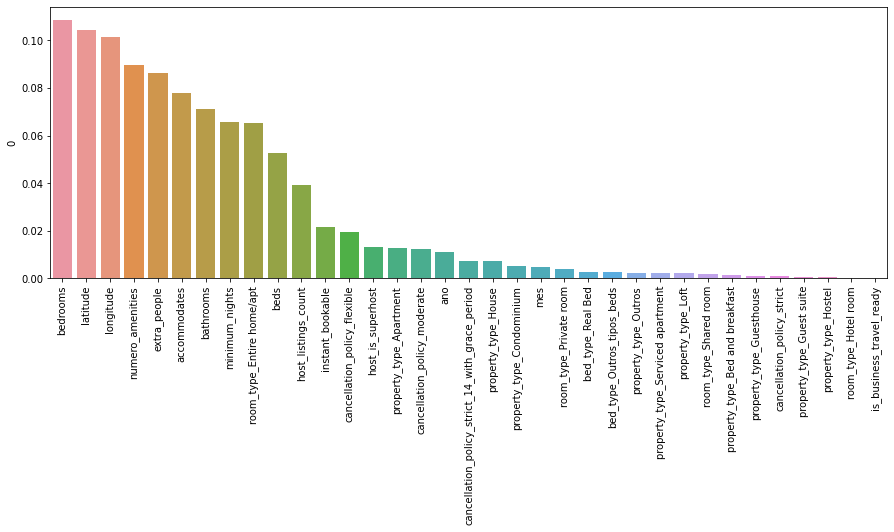

In [75]:
#print(modelo_ExtraTrees.feature_importances_)
#print(x_train.columns)
importancia_features = pd.DataFrame(data=modelo_ExtraTrees.feature_importances_, index=x_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)

plt.figure(figsize=(15,5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes Finais no Modelo

- A coluna "is_business_travel_ready" aparentemente não tem tanta relevância para o modelo. Desta forma, para chegarmos no modelo o mais simples possível com maior qualidade, iremos fazer a exclusão dessa feature.

In [76]:
base_airnb_enconding.columns

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable',
       'is_business_travel_ready', 'ano', 'mes', 'numero_amenities',
       'property_type_Apartment', 'property_type_Bed and breakfast',
       'property_type_Condominium', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_House', 'property_type_Loft', 'property_type_Outros',
       'property_type_Serviced apartment', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Outros_tipos_beds',
       'bed_type_Real Bed', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')

### Exclusão de colunas para melhorar o modelo

In [77]:
base_airnb_enconding = base_airnb_enconding.drop('is_business_travel_ready', axis=1)

In [78]:
y = base_airnb_enconding['price'] # Coluna/Valor que queremos calcular
x = base_airnb_enconding.drop('price', axis=1)


x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

#treinar
modelo_ExtraTrees.fit(x_train, y_train)
#testar
previsao = modelo_ExtraTrees.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))


Modelo ExtraTrees:
R²: 97.45%
RSME: 42.16

